In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [5]:
# Load and preprocess data
def load_and_preprocess_data(filepath):
    loc1 = pd.read_csv(filepath)
    loc1['Time'] = pd.to_datetime(loc1['Time'])
    loc1['Year'] = loc1['Time'].dt.year
    loc1['Month'] = loc1['Time'].dt.month
    features = ['Year', 'Month', 'temperature_2m', 'relativehumidity_2m', 
                'dewpoint_2m', 'windspeed_10m', 'windspeed_100m', 
                'winddirection_10m', 'winddirection_100m', 'windgusts_10m']
    X = loc1[features]
    y = loc1['Power']
    return X, y

In [6]:
# Function to remove outliers
def remove_outliers(X, y, threshold=3.0):
    features_to_check = X.columns.difference(['Year', 'Month'])
    z_scores = np.abs(X[features_to_check].apply(zscore))
    mask = (z_scores < threshold).all(axis=1)
    
    outliers_removed = {feature: np.sum(~mask & (z_scores[feature] >= threshold)) for feature in features_to_check}
    
    X_clean = X[mask]
    y_clean = y[mask]
    
    return X_clean, y_clean, outliers_removed

In [7]:
# Function to calculate adjusted R-squared
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [8]:
# Function to train and evaluate linear regression model
def train_and_evaluate_linear_regression(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    adj_r2 = adjusted_r2(r2, X_test.shape[0], X_test.shape[1])
    
    print('R^2:', r2)
    print('Adjusted R^2:', adj_r2)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('MAE:', mae)
    
    return X_train, X_test, y_train, y_test, y_pred


In [9]:
# Function for K-Fold Cross-Validation
def kfold_cross_validation(X, y, model):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    results = {'MSE': [], 'RMSE': [], 'MAE': [], 'R^2': [], 'Adj R^2': []}
    y_pred_all = []
    y_test_all = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        adj_r2 = adjusted_r2(r2, X_test.shape[0], X_test.shape[1])
        
        results['MSE'].append(mse)
        results['RMSE'].append(rmse)
        results['MAE'].append(mae)
        results['R^2'].append(r2)
        results['Adj R^2'].append(adj_r2)
        
        y_pred_all.extend(y_pred)
        y_test_all.extend(y_test)
    
    avg_results = {metric: np.mean(values) for metric, values in results.items()}
    std_results = {metric: np.std(values) for metric, values in results.items()}
    
    print("\nCross-Validation Results (Mean ± Std):")
    for metric, avg_value in avg_results.items():
        print(f"{metric}: {avg_value:.4f} ± {std_results[metric]:.4f}")
    
    return np.array(y_pred_all), np.array(y_test_all)

In [10]:
# Function to manually plot predictions
def plot_predictions(y_test_all, y_pred_all):
    fig, axs = plt.subplots(ncols=2, figsize=(12, 6))
    
    # Actual vs Predicted
    axs[0].scatter(y_test_all, y_pred_all, alpha=0.5)
    axs[0].plot([min(y_test_all), max(y_test_all)], [min(y_test_all), max(y_test_all)], color='red')
    axs[0].set_xlabel("Actual values")
    axs[0].set_ylabel("Predicted values")
    axs[0].set_title("Actual vs. Predicted values")
    
    # Residuals vs Predicted
    residuals = y_test_all - y_pred_all
    axs[1].scatter(y_pred_all, residuals, alpha=0.5)
    axs[1].hlines(0, min(y_pred_all), max(y_pred_all), color='red')
    axs[1].set_xlabel("Predicted values")
    axs[1].set_ylabel("Residuals")
    axs[1].set_title("Residuals vs. Predicted Values")
    
    plt.tight_layout()
    plt.show()

Number of outliers removed from each variable:
dewpoint_2m: 0 outliers
relativehumidity_2m: 11 outliers
temperature_2m: 5 outliers
winddirection_100m: 0 outliers
winddirection_10m: 0 outliers
windgusts_10m: 337 outliers
windspeed_100m: 199 outliers
windspeed_10m: 318 outliers
R^2: 0.6198606694164123
Adjusted R^2: 0.6194216080505268
MSE: 0.031218826875262385
RMSE: 0.17668850238558928
MAE: 0.13888527692381247

Cross-Validation Results (Mean ± Std):
MSE: 0.0303 ± 0.0007
RMSE: 0.1741 ± 0.0021
MAE: 0.1376 ± 0.0015
R^2: 0.6299 ± 0.0082
Adj R^2: 0.6290 ± 0.0082


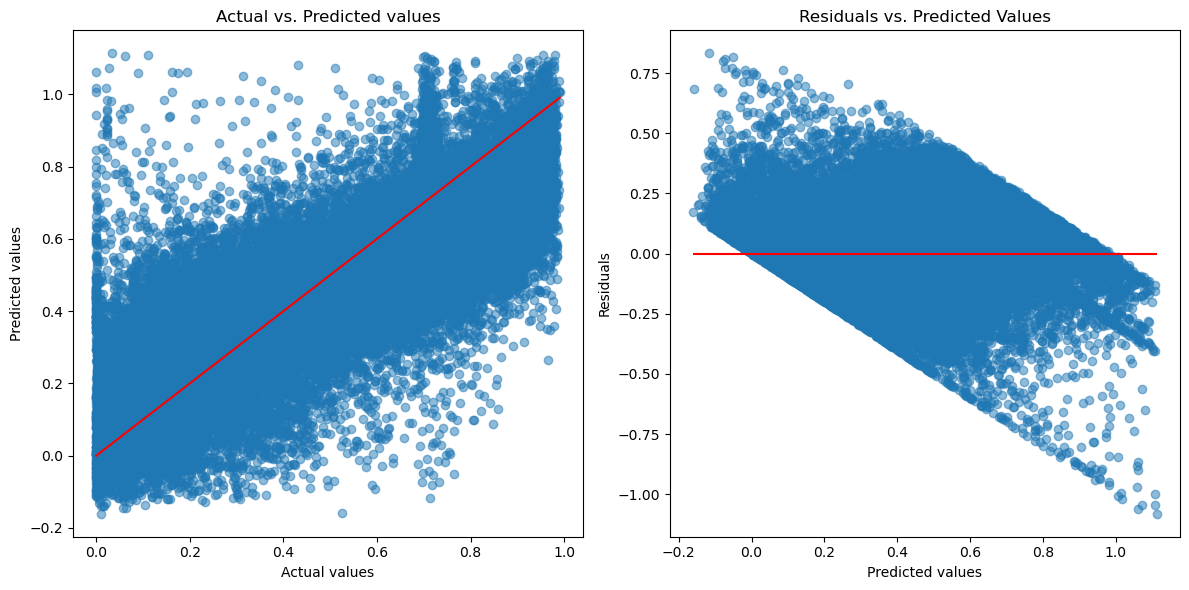


Results using highly correlated features:
R^2: 0.610890919310761
Adjusted R^2: 0.6107562017986932
MSE: 0.031955464873842536
RMSE: 0.1787609153977528
MAE: 0.1409925207250183


In [11]:
# Main script execution
if __name__ == "__main__":
    filepath = 'Location1.csv'
    
    # Load and preprocess data
    X, y = load_and_preprocess_data(filepath)
    
    # Remove outliers
    X_clean, y_clean, outliers_count = remove_outliers(X, y)
    print("Number of outliers removed from each variable:")
    for feature, count in outliers_count.items():
        print(f"{feature}: {count} outliers")
    
    # Train and evaluate Linear Regression model
    X_train, X_test, y_train, y_test, y_pred = train_and_evaluate_linear_regression(X_clean, y_clean)
    
    # K-Fold Cross-Validation
    y_pred_all, y_test_all = kfold_cross_validation(X_clean, y_clean, LinearRegression())
    
    # Manually plot predictions
    plot_predictions(y_test_all, y_pred_all)

    # Define features with high correlation to Power
    features_high_corr = ['windspeed_10m', 'windspeed_100m', 'windgusts_10m']
    X_high_corr = X_clean[features_high_corr]
    y_high_corr = y_clean

    # Scale and train Ridge model
    scaler = StandardScaler()
    X_scaled_high_corr = scaler.fit_transform(X_high_corr)
    X_train_high_corr, X_test_high_corr, y_train_high_corr, y_test_high_corr = train_test_split(X_scaled_high_corr, y_high_corr, test_size=0.2, random_state=42)
    
    model_high_corr = LinearRegression()
    model_high_corr.fit(X_train_high_corr, y_train_high_corr)
    
    y_pred_high_corr = model_high_corr.predict(X_test_high_corr)
    r_square_high_corr = r2_score(y_test_high_corr, y_pred_high_corr)
    mse_high_corr = mean_squared_error(y_test_high_corr, y_pred_high_corr)
    rmse_high_corr = np.sqrt(mse_high_corr)
    mae_high_corr = mean_absolute_error(y_test_high_corr, y_pred_high_corr)
    adj_r2_high_corr = adjusted_r2(r_square_high_corr, X_test_high_corr.shape[0], X_test_high_corr.shape[1])
    
    # Print results
    print("\nResults using highly correlated features:")
    print('R^2:', r_square_high_corr)
    print('Adjusted R^2:', adj_r2_high_corr)
    print('MSE:', mse_high_corr)
    print('RMSE:', rmse_high_corr)
    print('MAE:', mae_high_corr)

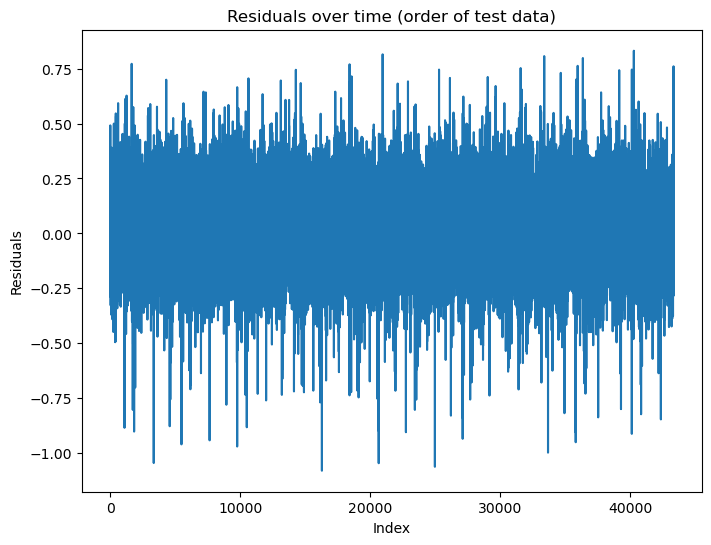

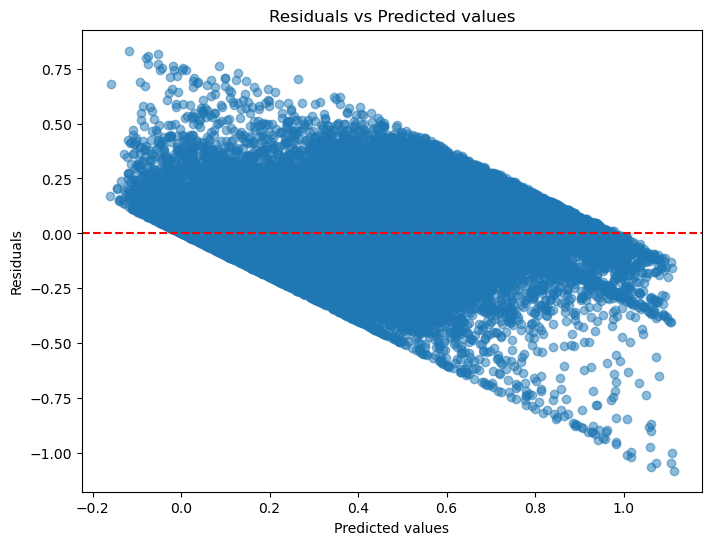

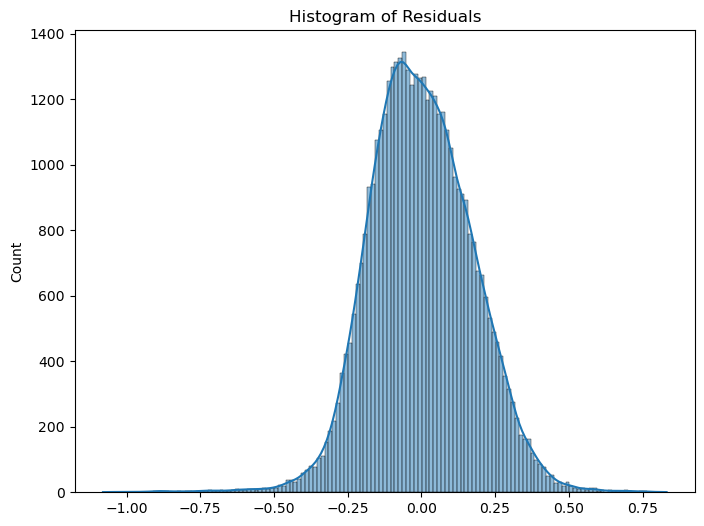

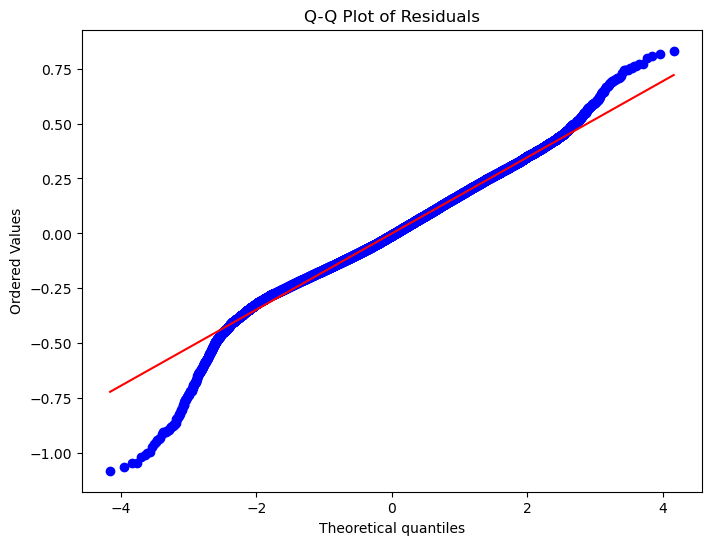

In [12]:
import seaborn as sns
import scipy.stats as stats

# Step 1: Check Linear Relationship via scatter plots (or already done)

# Step 2: Check Independence of Residuals
def check_independence_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.plot(residuals)
    plt.title('Residuals over time (order of test data)')
    plt.xlabel('Index')
    plt.ylabel('Residuals')
    plt.show()

# Step 3: Check Homoscedasticity (Residuals vs Fitted values)
def check_homoscedasticity(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs Predicted values')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.show()

# Step 4: Check Normality of Residuals via Histogram and Q-Q plot
def check_normality_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    
    # Histogram
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')
    plt.show()

    # Q-Q plot
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Residuals')
    plt.show()

# Applying the diagnostic tools for assumption checks
check_independence_residuals(y_test_all, y_pred_all)
check_homoscedasticity(y_test_all, y_pred_all)
check_normality_residuals(y_test_all, y_pred_all)